In [1]:
# !pip install transformers
# !pip install datasets
# !pip install sklearn
# !pip install emtions
# !pip install ipywidgets
# !pip install emojis
# !pip3 install umap-learn
# !pip install numba==0.53

In [2]:
import sys
sys.path.append('../assets/')

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Main libraries
from data_shuffling_split import *
from preprocess_text import *
from datasets import load_dataset, list_datasets, Dataset, DatasetDict, ClassLabel
from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import torch
from sklearn.dummy import DummyClassifier
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

In [5]:
dialect_datasets = load_dataset('Abdelrahman-Rezk/Arabic_Dialect_Identification', use_auth_token=True)
dialect_datasets

Using custom data configuration Abdelrahman-Rezk--Arabic_Dialect_Identification-256d82f412398eec
Reusing dataset parquet (/home/qblocks/.cache/huggingface/datasets/Abdelrahman-Rezk___parquet/Abdelrahman-Rezk--Arabic_Dialect_Identification-256d82f412398eec/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['id', 'label', 'text'],
        num_rows: 9164
    })
    train: Dataset({
        features: ['id', 'label', 'text'],
        num_rows: 440052
    })
    test: Dataset({
        features: ['id', 'label', 'text'],
        num_rows: 8981
    })
})

In [6]:
train_data = dialect_datasets['train']
print(train_data.column_names)
print("="*50)
print(train_data[0])
print("="*50)
print(train_data.features)
print("="*50)
print(train_data[:3])

['id', 'label', 'text']
{'id': 1046024946705735552, 'label': 9, 'text': '@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره بينا وبينه قصة عشق قديمة😍😍'}
{'id': Value(dtype='int64', id=None), 'label': ClassLabel(num_classes=18, names=['OM', 'SD', 'SA', 'KW', 'QA', 'LB', 'JO', 'SY', 'IQ', 'MA', 'EG', 'PL', 'YE', 'BH', 'DZ', 'AE', 'TN', 'LY'], id=None), 'text': Value(dtype='string', id=None)}
{'id': [1046024946705735552, 1140189387508134016, 1051416181855440768], 'label': [9, 17, 0], 'text': ['@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره بينا وبينه قصة عشق قديمة😍😍', '@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي بشعار الليڤر', '@OmanisFollowers @ooredoo @TRA_OMAN @motc_om هيه هيه م يتغير شي.. كلهم ع بعضهم متولفين😪.. بيجيك مدير فرع قريب منك عشان يتساعد معك عشان بس يثبت جدارته لوظيفيه فكرسيه ويحاول يتعاون معك لكن فالنهايه بترجع ع نفس المشكله والدائرة تدور لا بيقدموا ولا بيأخروا😪😪.. وحدي غاسله ايدي منهم']}


In [7]:
train_data.set_format(type="pandas")
df = train_data[:]
df.head()

,id,label,text
0,1046024946705735552,9,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...
1,1140189387508134016,17,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...
2,1051416181855440768,0,@OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...
3,781770259422412800,11,كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...
4,968140551366340608,11,#عزام 🔊\nاحنا ابو الولد وام الولد


In [8]:
def label_int2str(row):
    return train_data.features['label'].int2str(row)
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,id,label,text,label_name
0,1046024946705735552,9,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA
1,1140189387508134016,17,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY
2,1051416181855440768,0,@OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...,OM
3,781770259422412800,11,كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...,PL
4,968140551366340608,11,#عزام 🔊\nاحنا ابو الولد وام الولد,PL


In [9]:
train_data

Dataset({
    features: ['id', 'label', 'text'],
    num_rows: 440052
})

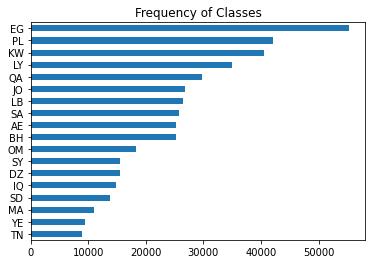

In [10]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

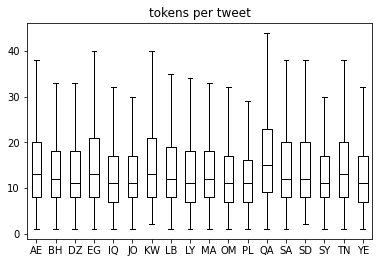

In [11]:
df['tokens per tweet'] = df['text'].str.split().apply(len)
df.boxplot("tokens per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
train_data.reset_format()

## From Text to Tokens

- تحديد انهى موديلز هنستخدمها
- تحديد التكوينزر الخاص بكل موديل
- التجريب على بعض الأمثلة من الداتا

https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-da

https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-msa

https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-msa-did-madar-twitter5?text=%D8%B9%D8%A7%D9%85%D9%84+%D8%A7%D9%8A%D9%87+%D8%9F

Edit tokenizer in our model to be limited to 124 word !?

## Subword Tokenization
The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings.

In [13]:
model_ckpt = "CAMeL-Lab/bert-base-arabic-camelbert-msa"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
some_text = train_data['text'][8]
some_text

'قلبي مقبوض ، بقالي كام يوم مش متظبط و اتمني ان دا يكون رواسب الزمن و متحصلش حاجه اوحش من اللي بيحصل ...'

In [15]:
encoded_text = tokenizer(some_text)
print(encoded_text)

{'input_ids': [2, 3018, 8755, 2175, 378, 10262, 1907, 3648, 2232, 2096, 2068, 1057, 2463, 415, 6228, 1939, 2720, 2461, 3275, 2024, 5579, 415, 8870, 2107, 1034, 3909, 2213, 24474, 1908, 2115, 27329, 2107, 18, 18, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [16]:
print(tokenizer.convert_ids_to_tokens(encoded_text['input_ids']))
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])))

['[CLS]', 'قلبي', 'مقب', '##وض', '،', 'بقا', '##لي', 'كام', 'يوم', 'مش', 'مت', '##ظ', '##بط', 'و', 'اتمني', 'ان', 'دا', 'يكون', 'روا', '##سب', 'الزمن', 'و', 'متح', '##صل', '##ش', 'حاجه', 'او', '##حش', 'من', 'اللي', 'بيح', '##صل', '.', '.', '.', '[SEP]']
[CLS] قلبي مقبوض ، بقالي كام يوم مش متظبط و اتمني ان دا يكون رواسب الزمن و متحصلش حاجه اوحش من اللي بيحصل... [SEP]


In [17]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30000
1000000000000000019884624838656
['input_ids', 'token_type_ids', 'attention_mask']


In [18]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

print(tokenize(train_data[:2]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[2, 36, 7329, 16696, 67, 44, 3263, 1118, 1049, 8903, 27238, 23212, 415, 5770, 7, 4206, 67, 7276, 16163, 25919, 6967, 8918, 15785, 1370, 1370, 3, 0, 0, 0, 0, 0], [2, 36, 86, 1089, 1050, 1021, 1069, 1084, 1052, 18100, 1115, 1025, 21542, 1077, 1025, 36, 94, 3263, 1052, 25287, 1050, 8191, 29359, 1908, 2115, 2331, 2685, 2115, 1225, 1017, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [19]:
batch = {}
batch['text'] = "الهدف من الحياة هو سث[MASK] . "
encoded_text = tokenize(batch)
print(encoded_text)
print(tokenizer.convert_ids_to_tokens(encoded_text['input_ids']))

{'input_ids': [2, 6078, 1908, 3696, 2139, 399, 1039, 4, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'الهدف', 'من', 'الحياة', 'هو', 'س', '##ث', '[MASK]', '.', '[SEP]']


### Model Special Token & ITs ids

In [20]:
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.mask_token, tokenizer.mask_token_id)

[PAD] 0
[UNK] 1
[CLS] 2
[SEP] 3
[MASK] 4


In [21]:
# batch_size=None to get the length inputs based on the large tweet
dialect_datasets_encoded = dialect_datasets.map(tokenize, batched=True, batch_size=1024)

Parameter 'function'=<function tokenize at 0x7fb9b1061790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/430 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

In [22]:
print(dialect_datasets_encoded.column_names)

{'validation': ['id', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'], 'train': ['id', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'], 'test': ['id', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask']}


In [23]:
# The AutoModel class converts the token encodings to embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
device

device(type='cuda')

In [25]:
inputs = tokenizer(some_text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 36])


In [26]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

In [27]:
# [batch_size, n_tokens, hidden_dim]
print(outputs.last_hidden_state.shape)

torch.Size([1, 36, 768])


In [28]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [29]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    # print("="*50)
    # print(tokenizer.model_input_names)
    # print(batch.items())
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [30]:
dialect_datasets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label", "token_type_ids"])

In [ ]:
dialect_datasets_hidden = dialect_datasets_encoded.map(extract_hidden_states, batched=True,  batch_size=128)

  0%|          | 0/72 [00:00<?, ?ba/s]

  0%|          | 0/3438 [00:00<?, ?ba/s]

In [ ]:
dialect_datasets_hidden["train"].column_names

In [ ]:
# # Scale features to [0,1] range
# X_scaled = MinMaxScaler().fit_transform(X_train)
# # Initialize and fit UMAP
# mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# # Create a DataFrame of 2D embeddings
# df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
# df_emb["label"] = y_train
# df_emb.head()

In [ ]:
# fig, axes = plt.subplots(2, 3, figsize=(7,5))
# axes = axes.flatten()
# cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#                       'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#                       'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
# labels = dialect_datasets["train"].features["label"].names

# for i, (label, cmap) in enumerate(zip(labels, cmaps)):
#     df_emb_sub = df_emb.query(f"label == {i}")
#     axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))

In [ ]:
df.head()

In [ ]:
dialect_datasets['test']

In [ ]:
la = pd.DataFrame({"label": dialect_datasets['test'].features['label'].names})
la

In [ ]:
def label_str2int(row):
    return train_data.features['label'].str2int(row)

In [ ]:
la['str'] = la['label'].apply(label_str2int)
la

In [ ]:
dialect_datasets_encoded

In [ ]:
ls_label = list(la['label'])
ls_int   = list(la['str'])

In [ ]:
id2labels = {
    
}

In [ ]:
for key, val in enumerate(ls_int):
    id2labels[val] = ls_label[key]
    
id2labels

In [ ]:
num_labels = len(set(train_data['label']))
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2labels).to(device))

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids # acutall
    preds = pred.predictions.argmax(-1) # predicted
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
batch_size = 32
logging_steps = len(dialect_datasets["train"]) // batch_size

model_name = f"{model_ckpt}-finetuned-Arabic_Dialect_Identification_model_1"
training_args = TrainingArguments(output_dir=model_name,
                                num_train_epochs=3,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                evaluation_strategy="epoch",
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                push_to_hub=True,
                                log_level="error")

In [ ]:
trainer = Trainer(model=model, args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=dialect_datasets_encoded["train"],
                eval_dataset=dialect_datasets_encoded["validation"],
                tokenizer=tokenizer)
trainer.train()

In [ ]:
preds_output = trainer.predict(dialect_datasets["validation"])
print(preds_output)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = dialect_datasets["validation"]['label']
labels = dialect_datasets["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)